In [1]:
import numpy as np

from astropy import units as u
from astropy.modeling import models, fitting
from astropy.nddata import StdDevUncertainty
from astropy import uncertainty
import specutils

from matplotlib import pyplot as plt
from astropy.visualization import quantity_support
quantity_support()

flamb = u.erg / u.angstrom /(u.cm**2)

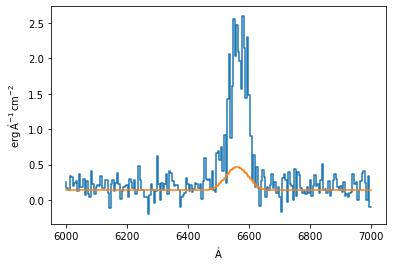

In [2]:
wl = np.linspace(6000, 7000, 200) * u.angstrom
line = models.Gaussian1D(amplitude=2*flamb, stddev=30*u.angstrom, mean=6563*u.angstrom)
continuum = models.Const1D(.2*flamb)
specmod = line + continuum

noiseless_flux = specmod(wl)
unc = (noiseless_flux*10/flamb)**0.5 * flamb / 10  # assume poisson w/ flux-to-counts of 20
flux = noiseless_flux + np.random.randn(len(wl))*unc

spec = specutils.Spectrum1D(spectral_axis=wl, flux=flux, uncertainty=StdDevUncertainty(unc))

plt.step(spec.spectral_axis, spec.flux)
plt.step(spec.spectral_axis, spec.uncertainty.quantity)

# `Fitters`

<CompoundModel(amplitude_0=2.11014829 erg / (Angstrom cm2), mean_0=6568.83392268 Angstrom, stddev_0=28.74021437 Angstrom, amplitude_1=0.19356288 erg / (Angstrom cm2))>

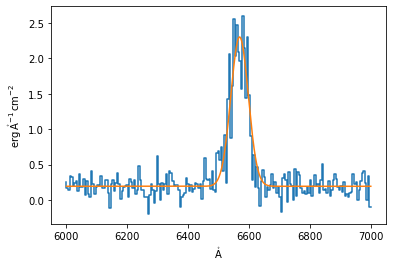

In [3]:
fitter = fitting.LevMarLSQFitter()
fittedmod = fitter(specmod, spec.spectral_axis, spec.flux)

plt.step(spec.spectral_axis, spec.flux)

x = np.linspace(6000, 7000, 1000) *u.angstrom
plt.plot(x, fittedmod(x))

fittedmod

w/ uncertainties:

<CompoundModel(amplitude_0=2.14459997 erg / (Angstrom cm2), mean_0=6567.20917416 Angstrom, stddev_0=28.14879947 Angstrom, amplitude_1=0.19398602 erg / (Angstrom cm2))>

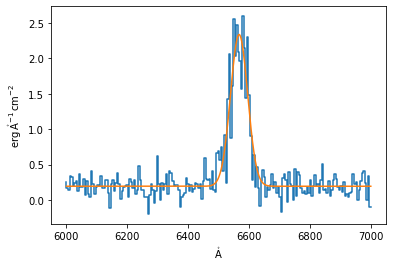

In [4]:
# inverse variance weighting

wfitter = fitting.LevMarLSQFitter()
wfittedmod = wfitter(specmod, spec.spectral_axis, spec.flux, weights=1/spec.uncertainty.quantity)

plt.step(spec.spectral_axis, spec.flux)

x = np.linspace(6000, 7000, 1000) *u.angstrom
plt.plot(x, wfittedmod(x))

wfittedmod

## Handling uncertainties for fitters

## Option 1: `uncertainty` attributes 

First cell hacks together something to work for examples' sake

In [5]:
#CURRENTLY:
cov = fitter.fit_info['param_cov']
wcov = wfitter.fit_info['param_cov']

fittedmod.fitted_param_covariance = cov
for nm, unc in zip(fittedmod.param_names, np.diag(cov)**0.5):
    param = getattr(fittedmod, nm)
    param.uncertainty = StdDevUncertainty(unc, unit=param.unit)
    
wfittedmod.fitted_param_covariance = wcov.value  # units don't make sense here as they are heterogenous anyway
for nm, unc in zip(wfittedmod.param_names, np.diag(wcov.value)**0.5):
    param = getattr(wfittedmod, nm)
    param.uncertainty = StdDevUncertainty(unc, unit=param.unit)

Note that `param_cov` already exists but the above renames it to the more readable `fitted_param_covariance`:

In [6]:
fittedmod.fitted_param_covariance

array([[ 5.98215229e-03,  1.48589936e-03, -5.00810428e-02,
        -1.65249377e-04],
       [ 1.48589936e-03,  1.45111571e+00, -2.02387143e-02,
        -3.60935443e-10],
       [-5.00810428e-02, -2.02387143e-02,  1.53756038e+00,
        -4.50199054e-03],
       [-1.65249377e-04, -3.60935443e-10, -4.50199054e-03,
         2.33697909e-04]])

A parameter's uncertainty can then be accessed as:

In [7]:
fittedmod.mean_0.uncertainty

StdDevUncertainty(1.20462264)

Which behaves like an `nddata`-style uncertainty:

In [8]:
fittedmod.mean_0.uncertainty.quantity

<Quantity 1.20462264 Angstrom>

As an example of a relevant calculation, percent uncertainty is then just:

In [9]:
for pnm in fittedmod.param_names:
    p = getattr(fittedmod, pnm)
    print(pnm, ':', 100* p.uncertainty.quantity / p, '%')

amplitude_0 : 3.6653525774720754 %
mean_0 : 0.018338454842950783 %
stddev_0 : 4.314456421419317 %
amplitude_1 : 7.897785659191898 %


For comparison, including uncertainties in the *fit* yields quite different, and generally larger uncertainties (as expected):

In [10]:
for pnm in wfittedmod.param_names:
    p = getattr(wfittedmod, pnm)
    print(pnm, ':', 100* p.uncertainty.quantity / p, '%')

amplitude_0 : 7.5871762544414985 %
mean_0 : 0.030161255390274488 %
stddev_0 : 6.088961493812597 %
amplitude_1 : 5.593090967433089 %


### Option 2: `Distributions` 

### Option 2a: a `distribution` attribute

In [11]:
for pnm in wfittedmod.param_names:
    param = getattr(wfittedmod, nm)
    param.distribution = uncertainty.normal(center=param.quantity, 
                                            std=param.uncertainty.quantity,
                                            n_samples=1000)

In [12]:
samples = np.random.multivariate_normal(wfittedmod.parameters, 
                                        wfittedmod.fitted_param_covariance, 
                                        size=1000)

for pnm, samp in zip(wfittedmod.param_names, samples.T): 
    param = getattr(wfittedmod, pnm)
    param.distribution = uncertainty.Distribution(samp*param.unit)

In [13]:
wfittedmod.mean_0.distribution.pdf_std()

<Quantity 1.93984694 Angstrom>

Note the answer is *slightly* different vs the above due to the impact of covarance.  But that's *real*.

In [14]:
for pnm in fittedmod.param_names:
    param = getattr(wfittedmod, pnm)
    relunc = param.distribution.pdf_smad()/ param.distribution.pdf_median()
    print(pnm, ':', relunc*100, '%')

amplitude_0 : 7.425631967194331 %
mean_0 : 0.028685330946712488 %
stddev_0 : 6.5460637375561905 %
amplitude_1 : 5.363885122029419 %


Almost the same answers as the above.

## Option 2b: 

Have the *value* of the parameter get set to the parameter distribution.  This should then yield distributions when the model is evaluated.  This does not work rgiht now:

In [15]:
# DOES NOT WORK CURRENTLY
fittedmod_option2 = wfittedmod.copy()
for pnm in fittedmod_option2.param_names:
    param = getattr(fittedmod_option2, pnm)
    param.value = uncertainty.Distribution(param.distribution.value[0])
type(param.value) #should be a distribution...

numpy.float64

But lets mock up the expected result:

In [16]:
def _fake_model_func(wl, amp, m, s, amp_cont):
    return amp * np.exp(-0.5*((wl-m)/s)**2) + amp_cont

dist_result = _fake_model_func([6563]*u.Angstrom, 
                 wfittedmod.amplitude_0.distribution,
                 wfittedmod.mean_0.distribution,
                 wfittedmod.stddev_0.distribution,
                 wfittedmod.amplitude_1.distribution)


regular_result = wfittedmod([6563]*u.Angstrom)

dist_result.pdf_median(), regular_res

NameError: name 'regular_res' is not defined

But the beauty of this is that there is now effectively an uncertainty *on the result* that's driven by the uncertainty in the parameters:

In [17]:
_fake_model_func([6263]*u.Angstrom, 
                 wfittedmod.amplitude_0.distribution,
                 wfittedmod.mean_0.distribution,
                 wfittedmod.stddev_0.distribution,
                 wfittedmod.amplitude_1.distribution).pdf_percentiles(99)

<Quantity [0.2180911] erg / (Angstrom cm2)>

We can take this one step further and actually visualize the uncertainty in the model iteslf:

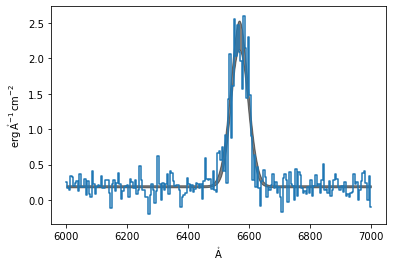

In [18]:
x = np.linspace(6000, 7000, 1000)*u.angstrom
dist_result = _fake_model_func(x, 
                 wfittedmod.amplitude_0.distribution,
                 wfittedmod.mean_0.distribution,
                 wfittedmod.stddev_0.distribution,
                 wfittedmod.amplitude_1.distribution)

plt.step(spec.spectral_axis, spec.flux, where='mid')
plt.fill_between(x, 
                 dist_result.pdf_percentiles(10), 
                 dist_result.pdf_percentiles(90), 
                 color='k', alpha=.5)

This is the uncertainty of the *model*, not the data, so it's tighter than the data, but it show the appropriate behavior of spreading out at the peak due to more relative uncertainty there.

### Option 3: *Both* 

Have both "uncertainties" and "distribution" get populated, but without the setting-to-value. The evaluate-with-distributions maybe could be implemented as a new method on the model?  Ambiguous if a lot of the modeling machinery breaks for that, though...

## Missing uncertainties

If a model is not the result of a fit and the user asks for uncertainties, just tell them they are not present

In [19]:
# This first line raises the intended error to visualize the intent of what should happen in the second line
raise ValueError('Model parameter "mean_0" does not have uncertainty')

specmod.mean_0.uncertainty

ValueError: Model parameter "mean_0" does not have uncertainty

If a fitter does not have "built-in" uncertainty estimate, it should not be on by default since that will slow things down.  But the error should inform the user about the situation:

In [20]:
sfitter = fitting.SimplexLSQFitter()
sfittedmod = sfitter(specmod, spec.spectral_axis, spec.flux)

# This first line raises the intended error to visualize the intent of what should happen in the second line
raise ValueError('Model parameter "mean_0" does not have uncertainty. You may need to turn on uncertainty estimation in the fitter')

sfittedmod.mean_0.uncertainty

ValueError: Model parameter "mean_0" does not have uncertainty. You may need to turn on uncertainty estimation in the fitter

But if they ask for it explicitly it should be possible:

In [21]:
sfitter = fitting.SimplexLSQFitter(estimate_uncertainty=True)
sfittedmod = sfitter(specmod, spec.spectral_axis, spec.flux)

sfittedmod.mean_0.uncertainty

TypeError: __init__() got an unexpected keyword argument 'estimate_uncertainty'

# Samplers

* priors as scipy stats models
* provide noise model as models w/ joined mean model output to a paremter
* value vs posterior - what would it look like for one or both to be a distribution?
* how to pass in uncertainties and have them used in the noise model

The remainder is more prototype-y because nothing in it actually works.  But it illustrates the idea:

In [ ]:
sampler = fitting.EmceeSampler(nsamples=10000)

# default case uses improper uniform priors, assumes gaussian/leastsquare noise model, assumes sigma in noise model is unity

sampledmod = sampler(specmod, spec.spectral_axis, spec.flux)

OR:

In [ ]:
sampler = fitting.EmceeSampler()

# default case uses improper priors, assumes gaussian/leastsquare noise model, assumes sigma in noise model is unity

sampledmod = sampler(specmod, spec.spectral_axis, spec.flux, nsamples=5000)
sampledmod = sampler(sampledmod, spec.spectral_axis, spec.flux, nsamples=5000)  # <- adds to the chain

In [ ]:
assert isinstance(sampledmod.mean_0.posterior, uncertainty.Distribution)

From there on, everything can be used as in the Distribution case above - they behave exactly like regular MCMC chains when you want them to, or as propogatable quantities when you want them to work that way.

But one of the advantages of sampled distributions is that they can give non-symmetric errors:

In [ ]:
for pnm in fittedmod.param_names:
    param = getattr(wfittedmod, pnm)
    med = param.posterior.pdf_median()
    low = param.posterior.pdf_percentile(31)
    high = param.posterior.pdf_percentile(69)
    print(pnm, ':', med, '+', high - med, '-', med - low)

## Add-on for Option 1 & 3

If Option 1 is followed above, adding an uncertainty attribute is called for:

In [ ]:
assert sampledmod.mean_0.uncertainty == sampledmod.mean_0.pdf_std()

The assumption that the user always wants the Std instead of a different estimator is an assumption - some users might prefer the 31-64 percentile range or the SMAD or similar. But such is the price for forcing a Bayesian to be frequentist (or vice versa)?

## Add-on for Option 2 & 3

As phrased above the API is *incompatible* with the APIs for options 2 and 3 above, which is bad for using fitters in a "swappable" manner.  Options to addresses this include:

* have `posterior` and `distribution` be aliases for the same thing
* if option 3b is taken, have `posterior` point to `value` for a sampler result, but raise an error if otherwise used
* use only `distributions` instead of `posterior`, and remove `posterior` entirely

# More on Samplers

* `param.priors` could be scipy.stats models
* `model.noise_model` could be NoiseModel(scipy_stats_model, mean_param_name, unc_param_name
* `uncertainty` should be a valid fitter input, which superceded `weights`